# Import Packages / Libraries

In [1]:
import pandas as pd
import numpy as np
import re, nltk, spacy, gensim
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#sklearn
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#sentiment analysis
from textblob import TextBlob

#pickling
import pickle

In [48]:
import seaborn as sns

# Import Data

In [7]:
df = pd.read_csv('clean7.csv')

In [8]:
df.head()

,artist,title,lyrics,source
0,10000 maniacs,more than this,i could feel at the time. there was no way of ...,sixgen
1,10000 maniacs,because the night,"take me now, baby, here as i am. hold me close...",sixgen
2,10000 maniacs,these are days,these are. these are days you'll remember. nev...,sixgen
3,10000 maniacs,a campfire song,"a lie to say, ""o my mountain has coal veins an...",sixgen
4,10000 maniacs,everyday is like sunday,trudging slowly over wet sand. back to the ben...,sixgen


# Check Out Data

In [11]:
df.tail()

,artist,title,lyrics,source
66907,nayara portela,sign of the times (harry styles cover),just stop your crying. it's a sign of the time...,sixgen
66908,nayara portela,stay (rihanna cover),all along it was a fever. a cold sweat hot-hea...,sixgen
66909,nayara portela,when i was your man (bruno mars cover),"same bed, but it feels just a little bit bigge...",sixgen
66910,sambo,"sunday, bloody sunday",i can't believe the news today. i can't close ...,sixgen
66911,zeca pagodinho,deixa a vida me levar (translation),i've been. for almost everything in life. in t...,sixgen


In [12]:
df.shape

(66912, 4)

# Preparing Data for NLP

## Regex

In [13]:
# Convert to list
data = df.lyrics.values.tolist()

# Remove new line characters
data = [re.sub('s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("'", "", sent) for sent in data]

pprint(data[:1])

['i could feel at the time. there wa  no way of knowing. fallen leave  in the '
 'night. who can  ay where theyre blowing. a  free a  the wind. hopefully '
 'learning. why the  ea on the tide. ha  no way of turning. more than thi . '
 'you know there  nothing. more than thi . tell me one thing. more than thi . '
 'you know there  nothing. it wa  fun for a while. there wa  no way of '
 'knowing. like a dream in the night. who can  ay where were going. no care in '
 'the world. maybe im learning. why the  ea on the tide. ha  no way of '
 'turning. more than thi . you know there  nothing. more than thi . tell me '
 'one thing. more than thi . you know there  nothing. more than thi . you know '
 'there  nothing. more than thi . tell me one thing. more than thi . there  '
 'nothing.']


## Tokenize & Clean with Gensim

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [16]:
df_words = list(sent_to_words(data))
print(df_words[:1])

[['could', 'feel', 'at', 'the', 'time', 'there', 'wa', 'no', 'way', 'of', 'knowing', 'fallen', 'leave', 'in', 'the', 'night', 'who', 'can', 'ay', 'where', 'theyre', 'blowing', 'free', 'the', 'wind', 'hopefully', 'learning', 'why', 'the', 'ea', 'on', 'the', 'tide', 'ha', 'no', 'way', 'of', 'turning', 'more', 'than', 'thi', 'you', 'know', 'there', 'nothing', 'more', 'than', 'thi', 'tell', 'me', 'one', 'thing', 'more', 'than', 'thi', 'you', 'know', 'there', 'nothing', 'it', 'wa', 'fun', 'for', 'while', 'there', 'wa', 'no', 'way', 'of', 'knowing', 'like', 'dream', 'in', 'the', 'night', 'who', 'can', 'ay', 'where', 'were', 'going', 'no', 'care', 'in', 'the', 'world', 'maybe', 'im', 'learning', 'why', 'the', 'ea', 'on', 'the', 'tide', 'ha', 'no', 'way', 'of', 'turning', 'more', 'than', 'thi', 'you', 'know', 'there', 'nothing', 'more', 'than', 'thi', 'tell', 'me', 'one', 'thing', 'more', 'than', 'thi', 'you', 'know', 'there', 'nothing', 'more', 'than', 'thi', 'you', 'know', 'there', 'nothing'

## Lemmatize Using SpaCy

In [17]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser'])

In [19]:
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(df_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Remove Stop Words

### Update Stop Words with Task Specific Words

In [22]:
stop = list(text.ENGLISH_STOP_WORDS)

In [23]:
new_words = ["\'ll", 'im', 've', 'll', 'ah', 'aaaah', 'na', 'hey', 'oh', 'em', 'hoo', 'ay', 'eh', 'ho', 'huh', 'uh', 'ooh', 'dum', 'woo', 'eh', 'woah', 'la', 'peopleâ', 'yeahhahahhhahhhhhahhh', 'oohhh', 'yaaaaa', 'don', '12', '10']

In [24]:
stop_words = text.ENGLISH_STOP_WORDS.union(new_words)

## Create Document Word Matrix

In [25]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
                             max_df = .98,                      # minimum reqd occurences of a word | abs val
                             stop_words = stop_words,           # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )

In [26]:
data_vectorized = vectorizer.fit_transform(data_lemmatized)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['people'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Check for Scrantonicity.. just kidding

### Check for Sparsicity

In [27]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

In [28]:
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.367317457176506 %


# Build Model

In [29]:
lda_model_best = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=11, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=20)

In [202]:
lda_model_best_output = lda_model_best.fit_transform(data_vectorized)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   54.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   56.0s remaining:   56.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   57.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   46.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   48.9s remaining:   48.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   49.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   49.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   45.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   47.3s remaining:   47.3s


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   45.3s remaining:   45.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   45.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   45.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   42.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   43.3s remaining:   43.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   43.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   43.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   41.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   41.4s remaining:   41.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   42.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   42.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.4s remaining:   36.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   27.5s remaining:   27.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   28.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   39.9s remaining:   39.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.0s finished


# Diganose Model Performance & Log Likelihood -

In [203]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model_best.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model_best.perplexity(data_vectorized))

# See model parameters
pprint(lda_model_best.get_params())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   37.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.8s remaining:   37.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.1s finished


Log Likelihood:  -37804553.11081377


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s finished


Perplexity:  986.3514986903683
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.5,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 11,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 20}


# GridSearch for Best LDA -

In [204]:
# Define Search Param
search_params = {'n_components': [11], 'learning_decay': [.5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

# Best Models - 

In [205]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 11}
Best Log Likelihood Score:  -12862040.404500669
Model Perplexity:  981.6317963052842


# Get Log Likelyhoods from Grid Search Output

In [206]:
model.cv_results_['mean_test_score'][0]

-12862040.404500669

In [208]:
log_likelyhoods_5 = model.cv_results_['mean_test_score']

In [211]:
log_likelyhoods_5

array([-12862040.40450067])

# Diagnose Model Performance w/Perplexity & Log Likelihood

In [ ]:
#Topic Coherence would maybe make a better parameter to judge by.

In [167]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model_best.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model_best.perplexity(data_vectorized))

# See model parameters
pprint(lda_model_best.get_params())

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   39.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   40.1s remaining:   40.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.8s finished


Log Likelihood:  -37812699.82621907


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   45.4s remaining:   45.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   46.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   46.6s finished


Perplexity:  987.8179406197586
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.5,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 11,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 20}


# Fit The Model to the Data

In [30]:
best_lda_output = lda_model_best.fit_transform(data_vectorized)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   49.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   52.0s remaining:   52.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   52.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   52.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   47.5s remaining:   47.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   46.6s remaining:   46.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   43.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   44.8s remaining:   44.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   45.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   45.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   40.0s remaining:   40.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   39.9s remaining:   39.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   43.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   43.5s remaining:   43.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   44.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   44.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.4s remaining:   33.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.0s remaining:   34.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.4s finished


# See Topic's Keywords

In [178]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model_best.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaaaah,aaah,aac,aah,aahh,aaliyah,aaron,abandon,abbath,abbey,...,zion,zip,zipper,zodiac,zoe,zombie,zone,zoo,zoom,zulu
Topic0,0.090918,0.090915,0.090919,2.803317,0.090915,0.090919,0.090935,19.111113,2.085945,0.090916,...,0.090918,2.735722,0.090912,0.090920,0.090910,0.090923,3.511628,15.047381,0.090915,0.090917
Topic1,1.715612,0.090930,3.867413,0.094721,0.090913,13.451960,0.090961,4.270634,0.090917,0.090920,...,0.339137,71.387336,24.419291,9.093539,15.988029,25.946880,377.634927,33.850581,15.331679,10.633344
Topic2,0.090911,5.489565,0.090910,0.411001,0.124827,0.090910,3.114985,1.637017,0.090915,0.090909,...,0.090910,0.090915,0.090911,0.090911,0.090910,0.090912,0.090915,0.090912,0.090913,0.090911
Topic3,0.576799,0.090918,23.390255,0.090917,0.090911,0.090914,1.693028,155.136004,19.610225,12.156811,...,67.801717,0.090916,0.090914,0.090920,13.449152,0.162859,73.677171,0.090916,2.849371,0.090913
Topic4,0.090924,0.090917,0.090913,0.198271,2.435943,2.321964,3.294046,0.094438,0.090910,2.924116,...,0.090915,0.090918,3.152568,0.090916,0.090912,0.090915,218.742379,0.489615,0.091213,0.090912


In [31]:
#grab a list of vocab of words
vocabulary = vectorizer.get_feature_names()

In [34]:
vocabulary

['aaaaah',
 'aaah',
 'aac',
 'aah',
 'aahh',
 'aaliyah',
 'aaron',
 'abandon',
 'abbath',
 'abbey',
 'abc',
 'abduct',
 'abduction',
 'abdul',
 'abe',
 'abel',
 'aber',
 'abhor',
 'abi',
 'abide',
 'ability',
 'ablaze',
 'able',
 'aboard',
 'abode',
 'abort',
 'abortion',
 'abotage',
 'abound',
 'abra',
 'abracadabra',
 'abraham',
 'abre',
 'abroad',
 'abrupt',
 'abu',
 'aby',
 'academy',
 'acapella',
 'acapulco',
 'acce',
 'accelerate',
 'accent',
 'accept',
 'acceptance',
 'accident',
 'accidental',
 'accidentally',
 'acclaim',
 'accompany',
 'accompli',
 'accord',
 'account',
 'accountable',
 'accountant',
 'accro',
 'accu',
 'accumulate',
 'accurate',
 'ace',
 'ache',
 'achieve',
 'achievement',
 'achille',
 'achin',
 'aching',
 'acid',
 'ack',
 'acknowledge',
 'acou',
 'acquaint',
 'acquaintance',
 'acquire',
 'acrament',
 'acre',
 'acred',
 'acrifice',
 'acrificial',
 'acro',
 'acrobat',
 'acrobatic',
 'act',
 'actavi',
 'actin',
 'acting',
 'action',
 'activate',
 'active',
 'ac

In [179]:
#grab the topics
lda_model_best.components_

array([[9.09184520e-02, 9.09153098e-02, 9.09185759e-02, ...,
        1.50473806e+01, 9.09148920e-02, 9.09173812e-02],
       [1.71561184e+00, 9.09303812e-02, 3.86741279e+00, ...,
        3.38505811e+01, 1.53316785e+01, 1.06333436e+01],
       [9.09107573e-02, 5.48956483e+00, 9.09102779e-02, ...,
        9.09119498e-02, 9.09125404e-02, 9.09112694e-02],
       ...,
       [9.09147849e-02, 9.09148009e-02, 9.09119928e-02, ...,
        9.09131844e-02, 9.09117251e-02, 9.09128803e-02],
       [2.38098869e+01, 1.08790959e+01, 9.09194616e-02, ...,
        2.02452070e+01, 9.54294698e+00, 9.09107190e-02],
       [3.57364771e+00, 9.40776622e-02, 9.09126407e-02, ...,
        1.16821718e+02, 9.09186876e-02, 4.54844190e+00]])

In [180]:
lda_model_best.components_.shape

(11, 12043)

# Show Top Words For Each Topic

In [35]:
#grab highest probability words per topic
for i,topic in enumerate(lda_model_best.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{i}')
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-15:]])
    print('\n')
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['river', 'old', 'gun', 'town', 'drink', 'beautiful', 'low', 'burn', 'ride', 'city', 'night', 'hot', 'new', 'day', 'run']




THE TOP 15 WORDS FOR TOPIC #1
['thing', 'bad', 'feel', 'time', 'cau', 'way', 'think', 'need', 'want', 'ill', 'tell', 'girl', 'make', 'know', 'love']




THE TOP 15 WORDS FOR TOPIC #2
['dead', 'elf', 'kill', 'lie', 'know', 'free', 'fight', 'end', 'time', 'die', 'live', 'world', 'let', 'thi', 'life']




THE TOP 15 WORDS FOR TOPIC #3
['hot', 'wit', 'hoe', 'let', 'come', 'gon', 'cau', 'know', 'make', 'money', 'bitch', 'thi', 'fuck', 'hit', 'nigga']




THE TOP 15 WORDS FOR TOPIC #4
['long', 'boy', 'remember', 'omebody', 'thing', 'year', 'ill', 'elf', 'come', 'time', 'tma', 'chri', 'wait', 'thi', 'home']




THE TOP 15 WORDS FOR TOPIC #5
['body', 'time', 'feel', 'need', 'come', 'right', 'make', 'rock', 'girl', 'good', 'know', 'want', 'let', 'wanna', 'baby']




THE TOP 15 WORDS FOR TOPIC #6
['hold', 'ill', 'try', 'make', 'break', 'feel'

# Best Topic Results

In [36]:
best_topics = lda_model_best.fit_transform(data_vectorized)
#same as above since there is no split of testing/training

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   44.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   46.1s remaining:   46.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   46.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   46.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   38.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   39.3s remaining:   39.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   39.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   39.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   38.8s remaining:   38.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   39.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   39.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   49.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   50.1s remaining:   50.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   50.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   50.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   40.3s remaining:   40.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   41.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   41.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   40.1s remaining:   40.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   40.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   46.5s remaining:   46.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   47.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   28.9s remaining:   28.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   29.3s finished


In [37]:
best_topics.shape

(66912, 11)

In [38]:
best_topics[0].round(2)
#this shows you the probability % of it being the most
#similar to any of the ten models

array([0.  , 0.  , 0.  , 0.15, 0.4 , 0.44, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [39]:
best_topics[0].argmax()
#shows that it is most likely to belong to Topic 6

5

# ID Each Topic

In [63]:
# Create Document - Topic Matrix
lda_output = lda_model_best.transform(data_vectorized)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   33.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.9s remaining:   33.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.5s finished


In [64]:
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model_best.n_components)]

In [65]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

In [66]:
# Make the pandas dataframe
df_document_topics = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [67]:
df_document_topics.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
Doc0,0.0,0.0,0.00,0.15,0.4,0.44,0.0,0.0,0.00,0.00,0.00
Doc1,0.0,0.0,0.45,0.15,0.0,0.00,0.0,0.0,0.40,0.00,0.00
Doc2,0.0,0.0,0.00,0.25,0.0,0.44,0.0,0.0,0.15,0.14,0.00
Doc3,0.0,0.0,0.00,0.94,0.0,0.05,0.0,0.0,0.00,0.00,0.00
Doc4,0.0,0.0,0.00,0.34,0.0,0.00,0.0,0.0,0.00,0.56,0.09


In [69]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topics.values, axis=1)
df_document_topics['dominant_topic'] = dominant_topic

In [70]:
print(lda_output)
print(topicnames)
print(docnames)
print(df_document_topic)
print(dominant_topic)
print(df_document_topic)

[[0.00189414 0.001894   0.00189417 ... 0.00189412 0.00189411 0.00189409]
 [0.00090016 0.00090012 0.44737826 ... 0.40032647 0.00090021 0.00090018]
 [0.00165306 0.00165295 0.00165313 ... 0.15400265 0.143515   0.00165294]
 ...
 [0.13308758 0.00085771 0.27948343 ... 0.17016847 0.253453   0.15866113]
 [0.04743914 0.00108231 0.19522544 ... 0.00108229 0.33366108 0.00108236]
 [0.55344349 0.00075761 0.17395382 ... 0.00075764 0.00075769 0.02455721]]
['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10']
['Doc0', 'Doc1', 'Doc2', 'Doc3', 'Doc4', 'Doc5', 'Doc6', 'Doc7', 'Doc8', 'Doc9', 'Doc10', 'Doc11', 'Doc12', 'Doc13', 'Doc14', 'Doc15', 'Doc16', 'Doc17', 'Doc18', 'Doc19', 'Doc20', 'Doc21', 'Doc22', 'Doc23', 'Doc24', 'Doc25', 'Doc26', 'Doc27', 'Doc28', 'Doc29', 'Doc30', 'Doc31', 'Doc32', 'Doc33', 'Doc34', 'Doc35', 'Doc36', 'Doc37', 'Doc38', 'Doc39', 'Doc40', 'Doc41', 'Doc42', 'Doc43', 'Doc44', 'Doc45', 'Doc46', 'Doc47', 'Doc48', 'Doc49', 'Do

# Dominant Topic df

In [71]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topic_15 = df_document_topics.head(15).style.applymap(color_green).applymap(make_bold)

In [72]:
df_document_topic_15

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,dominant_topic
Doc0,0,0,0,0.15,0.4,0.44,0,0,0,0,0,5
Doc1,0,0,0.45,0.15,0,0,0,0,0.4,0,0,2
Doc2,0,0,0,0.25,0,0.44,0,0,0.15,0.14,0,5
Doc3,0,0,0,0.94,0,0.05,0,0,0,0,0,3
Doc4,0,0,0,0.34,0,0,0,0,0,0.56,0.09,9
Doc5,0,0,0.08,0.18,0.66,0,0,0,0,0.08,0,4
Doc6,0,0,0.32,0.66,0,0,0,0,0,0,0,3
Doc7,0.91,0,0,0.07,0,0,0,0,0,0,0,0
Doc8,0,0,0,0.49,0,0,0,0,0.13,0.36,0,3
Doc9,0,0,0,0.52,0,0,0.41,0.06,0,0,0,3


# Topics Across Documents

In [73]:
df_document_topics.head(2)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,dominant_topic
Doc0,0.0,0.0,0.00,0.15,0.4,0.44,0.0,0.0,0.0,0.0,0.0,5
Doc1,0.0,0.0,0.45,0.15,0.0,0.00,0.0,0.0,0.4,0.0,0.0,2


In [74]:
df_topic_distribution = df_document_topics['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,11847
1,2,9549
2,6,8064
3,1,7482
4,4,5889
5,5,5469
6,0,4750
7,8,4108
8,10,4069
9,9,2998


# Assign Dominant Topic To df

In [80]:
df['lda_topic'] = best_topics.argmax(axis =1)

In [81]:
df.head(2)

,artist,title,lyrics,source,lda_topic
0,10000 maniacs,more than this,i could feel at the time. there was no way of ...,sixgen,5
1,10000 maniacs,because the night,"take me now, baby, here as i am. hold me close...",sixgen,2


# Extract the Top 15 Words Per Topic

In [84]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model_best, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_best, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,life,make,world,thi,new,live,people,free,end,right,everybody,king,young,beat,bear
Topic 1,nigga,hit,fuck,money,bitch,thi,know,man,make,cau,hoe,come,tell,big,hot
Topic 2,baby,let,know,heart,ill,make,away,feel,hold,come,fall,eye,time,tonight,night
Topic 3,light,thi,eye,dream,come,away,burn,world,high,fly,fall,run,night,ion,tar
Topic 4,know,let,thi,wanna,good,make,tell,right,time,baby,cau,look,talk,work,think
Topic 5,know,feel,wanna,way,thing,think,omethe,thi,make,time,hear,chri,want,come,wait
Topic 6,time,long,ill,home,man,way,thi,know,try,old,leave,elf,live,wait,die
Topic 7,girl,want,boy,little,run,bad,man,know,pretty,wanna,look,world,woman,make,honey
Topic 8,love,need,know,want,tell,think,make,time,heart,way,hurt,thi,omeone,believe,feel
Topic 9,day,aid,come,night,think,wake,today,change,know,morning,leave,happy,party,thi,away


# Interactive Visualization

In [85]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model_best, data_vectorized, vectorizer, mds='tsne')
panel

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   32.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.8s remaining:   32.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.3s finished
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      -59.266510 -163.158417       1        1  13.693973
1      -97.676918   24.370548       2        1  13.421865
2      153.767410  -16.618021       3        1  11.685540
6       67.053398  -42.294025       4        1  10.556590
4      -10.993086   83.494637       5        1   9.820752
5      121.248665 -116.358543       6        1   7.917187
0        0.608773  -94.207504       7        1   7.365479
10     -94.080025  -71.324608       8        1   7.246901
8       45.213409 -174.030014       9        1   6.881551
7       79.208275   51.645046      10        1   5.737481
9      -11.718880   -8.292627      11        1   5.672680, topic_info=      Category           Freq      Term          Total  loglift  logprob
6855   Default  102177.000000      love  102177.000000  30.0000  30.0000
4624   Default   35877.000000      girl   35877.000000  29.0000  29.0000
11531  Default   51889.000000      want   51889.000000  28.0000  28.0000
6393   Default  109715.000000      know  109715.000000  27.0000  27.0000
702    Default   49334.000000      baby   49334.000000  26.0000  26.0000
2816   Default   32449.000000       day   32449.000000  25.0000  25.0000
6621   Default   53667.000000       let   53667.000000  24.0000  24.0000
7766   Default   17679.000000     nigga   17679.000000  23.0000  23.0000
11529  Default   35176.000000     wanna   35176.000000  22.0000  22.0000
1269   Default   16965.000000       boy   16965.000000  21.0000  21.0000
7689   Default   32742.000000      need   32742.000000  20.0000  20.0000
4075   Default   48050.000000      feel   48050.000000  19.0000  19.0000
2204   Default   65516.000000      come   65516.000000  18.0000  18.0000
2768   Default   12101.000000     dance   12101.000000  17.0000  17.0000
5128   Default   29845.000000     heart   29845.000000  16.0000  16.0000
9707   Default   10860.000000      rock   10860.000000  15.0000  15.0000
5300   Default   19773.000000       hit   19773.000000  14.0000  14.0000
4440   Default   13893.000000      fuck   13893.000000  13.0000  13.0000
211    Default   21278.000000       aid   21278.000000  12.0000  12.0000
6667   Default   31700.000000      life   31700.000000  11.0000  11.0000
10218  Default   35555.000000     think   35555.000000  10.0000  10.0000
7770   Default   29151.000000     night   29151.000000   9.0000   9.0000
5716   Default   35046.000000       ill   35046.000000   8.0000   8.0000
11584  Default   42039.000000       way   42039.000000   7.0000   7.0000
10217  Default   28471.000000     thing   28471.000000   6.0000   6.0000
6751   Default   21123.000000    little   21123.000000   5.0000   5.0000
11855  Default   25227.000000     world   25227.000000   4.0000   4.0000
1046   Default    8488.000000     bitch    8488.000000   3.0000   3.0000
671    Default   29289.000000      away   29289.000000   2.0000   2.0000
7021   Default   27701.000000       man   27701.000000   1.0000   1.0000
...        ...            ...       ...            ...      ...      ...
1043   Topic11     464.653740  birthday     650.748521   2.5327  -6.5065
8077   Topic11     403.469561     ooooh     560.023823   2.5416  -6.6477
3329   Topic11     790.435279     drunk    1384.431990   2.3090  -5.9752
10136  Topic11     994.904229    terday    1865.955898   2.2406  -5.7451
3414   Topic11     634.031236     early    1054.198344   2.3611  -6.1957
5187   Topic11    2366.355640      help    6949.585474   1.7922  -4.8787
1811   Topic11    3645.974313    change   12881.409760   1.6073  -4.4464
9971   Topic11    1434.720839     tarte    3531.002523   1.9689  -5.3791
8025   Topic11    1884.909165   omebody    5755.758097   1.7532  -5.1061
7770   Topic11    5516.373218     night   29151.809221   1.2047  -4.0323
6494   Topic11    1776.756030      late    5283.286521   1.7797  -5.1652
7207   Topic11    2018.173314      meet    6676.100015   1.6732 

# See Topics Keywords

In [86]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model_best.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaaaah,aaah,aac,aah,aahh,aaliyah,aaron,abandon,abbath,abbey,...,zion,zip,zipper,zodiac,zoe,zombie,zone,zoo,zoom,zulu
Topic0,0.090918,0.090915,0.090919,2.803317,0.090915,0.090919,0.090935,19.111113,2.085945,0.090916,...,0.090918,2.735722,0.090912,0.090920,0.090910,0.090923,3.511628,15.047381,0.090915,0.090917
Topic1,1.715612,0.090930,3.867413,0.094721,0.090913,13.451960,0.090961,4.270634,0.090917,0.090920,...,0.339137,71.387336,24.419291,9.093539,15.988029,25.946880,377.634927,33.850581,15.331679,10.633344
Topic2,0.090911,5.489565,0.090910,0.411001,0.124827,0.090910,3.114985,1.637017,0.090915,0.090909,...,0.090910,0.090915,0.090911,0.090911,0.090910,0.090912,0.090915,0.090912,0.090913,0.090911
Topic3,0.576799,0.090918,23.390255,0.090917,0.090911,0.090914,1.693028,155.136004,19.610225,12.156811,...,67.801717,0.090916,0.090914,0.090920,13.449152,0.162859,73.677171,0.090916,2.849371,0.090913
Topic4,0.090924,0.090917,0.090913,0.198271,2.435943,2.321964,3.294046,0.094438,0.090910,2.924116,...,0.090915,0.090918,3.152568,0.090916,0.090912,0.090915,218.742379,0.489615,0.091213,0.090912


# Ok, So Give Me A Playlist

In [88]:
df.tail()

,artist,title,lyrics,source,lda_topic
66907,nayara portela,sign of the times (harry styles cover),just stop your crying. it's a sign of the time...,sixgen,6
66908,nayara portela,stay (rihanna cover),all along it was a fever. a cold sweat hot-hea...,sixgen,4
66909,nayara portela,when i was your man (bruno mars cover),"same bed, but it feels just a little bit bigge...",sixgen,2
66910,sambo,"sunday, bloody sunday",i can't believe the news today. i can't close ...,sixgen,6
66911,zeca pagodinho,deixa a vida me levar (translation),i've been. for almost everything in life. in t...,sixgen,0


In [89]:
top0df = df[df['lda_topic'] == 0]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [90]:
top0df = df[df['lda_topic'] == 1]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [91]:
top0df = df[df['lda_topic'] == 2]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [92]:
top0df = df[df['lda_topic'] == 3]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [93]:
top0df = df[df['lda_topic'] == 4]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [230]:
top0df = df[df['lda_topic'] == 5]
df[['title', 'artist']].sample(n=20, random_state=777)

,title,artist
33378,malibu nights (secret track),tenacious d
16768,love came down at christmas,jars of clay
30883,out of hell,skillet
52912,santa baby (feat. liz gillies),ariana grande
61796,now that i know,mariah carey
6235,i apologise if you feel something,bring me the horizon
45322,ja rule loves us,ja rule
30841,should've when you could've,skillet
26683,miss impossible,poets of the fall
56730,carla/etude,elton john


In [ ]:
##### top0df = df[df['lda_topic'] == 6]
df[['title', 'artist']].sample(n=20, random_state=1)

In [96]:
top0df = df[df['lda_topic'] == 7]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [97]:
top0df = df[df['lda_topic'] == 8]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [98]:
top0df = df[df['lda_topic'] == 9]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


In [99]:
top0df = df[df['lda_topic'] == 10]
df[['title', 'artist']].sample(n=20, random_state=1)

,title,artist
40122,year one,x band
33576,go back to your woods,the band
2880,turn the other way,avenged sevenfold
60467,aphrodite,kharlles
53001,dirty work (feat. t-pain) (remix),austin mahone
22217,vivid red,misfits
14971,high on a horse,grand funk railroad
10495,strip song,dog eat dog
246,running out of days,3 doors down
56434,remember (part. dani furst),dubboy


# Cluster & Plot Similar Documents

In [100]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=33, random_state=16).fit_predict(lda_output)

In [101]:
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

In [102]:
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.21  0.24  0.44  0.6   0.23  0.24  0.36  0.13  0.2   0.16  0.17]
 [ 0.04  0.72  0.11 -0.62  0.24  0.07  0.07  0.08  0.06  0.05  0.1 ]]
Perc of Variance Explained: 
 [0.03 0.17]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

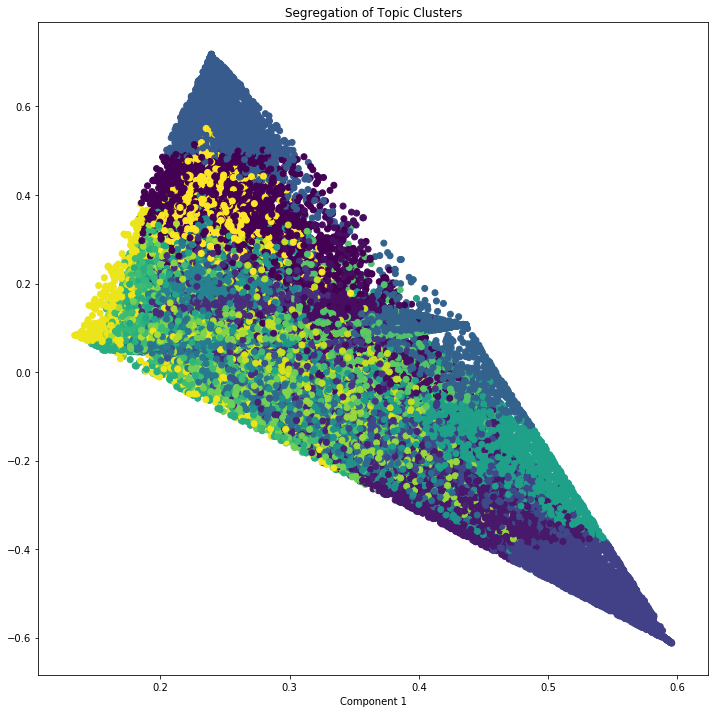

In [103]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# Assessing Model Performance

In [157]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model_best.score(data_vectorized))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.8s remaining:   33.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.3s finished


Log Likelihood:  -37812699.82621907


In [159]:
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model_best.perplexity(data_vectorized))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   35.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.7s remaining:   35.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s finished


Perplexity:  987.8179406197586


In [160]:
# See model parameters
pprint(lda_model_best.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.5,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 11,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 20}


# Predicting Topics For Unseen Data

In [213]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

In [214]:
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_output.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

In [215]:
#input lyrics to predict on
my_text = input("What are you listening to?: ") 
print(my_text) 

What are you listening to?: What are you listening to?: What are you listening to?: Combat, I'm ready for combat I say I don't want that, but what if I do? \'Cause cruelty wins in the movies I\'ve got a hundred thrown-out speeches I almost said to you Easy they come, easy they go I jump from the train, I ride off alone I never grew up, it's getting so old Help me hold onto you I've been the archer I've been the prey Who could ever leave me, darling? But who could stay?" Combat, I'm ready for combat I say I don't want that, but what if I do? \'Cause cruelty wins in the movies I\'ve got a hundred thrown-out speeches I almost said to you Easy they come, easy they go I jump from the train, I ride off alone I never grew up, it's getting so old Help me hold onto you I've been the archer I've been the prey Who could ever leave me, darling? But who could stay?
What are you listening to?: What are you listening to?: Combat, I'm ready for combat I say I don't want that, but what if I do? \'Cause

In [216]:
# Predict the topic
topic, prob_scores = predict_topic(text = my_text)
print(topic)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

# Find Similar Documents

In [152]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=20):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [156]:
# Get similar documents
mytext = ['''Combat, I'm ready for combat I say I don't want that, but what if I do? \'Cause cruelty wins in the movies I\'ve got a hundred thrown-out speeches I almost said to you Easy they come, easy they go I jump from the train, I ride off alone I never grew up, it's getting so old Help me hold onto you I've been the archer I've been the prey Who could ever leave me, darling? But who could stay?" Combat, I'm ready for combat I say I don't want that, but what if I do? \'Cause cruelty wins in the movies I\'ve got a hundred thrown-out speeches I almost said to you Easy they come, easy they go I jump from the train, I ride off alone I never grew up, it's getting so old Help me hold onto you I've been the archer I've been the prey Who could ever leave me, darling? But who could stay?''']
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
#print('\n', docs[0][:500])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Topic KeyWords:  [0.5767988244601884, 0.09091801075749353, 23.3902546774013, 0.09091691674864229, 0.0909112867447204, 0.09091427560360289, 1.693028493703513, 155.1360041634857, 19.61022510090149, 12.15681061251419, 0.09091380424364665, 0.09097998465892235, 0.09091740255938847, 0.09091342824458802, 0.09091025659688531, 22.535165097185324, 0.09094903994392221, 0.09093134904276869, 0.09091133336080161, 45.02396817846143, 2.8268213506564006, 42.72355047023664, 55.59864839086982, 11.73994411533861, 0.09092501098468003, 3.36624695370036, 0.09091572886905934, 0.09092902962044956, 39.81789361109398, 7.409138981945371, 0.09092160564500937, 14.635183090976025, 0.09092990498807346, 11.096859869509348, 3.48332190403104, 6.568855371248777, 69.02827211935319, 4.844201616520891, 0.0909108850716652, 0.09091411666116558, 0.09092215829472666, 0.0909180428953383, 0.0909151129610795, 33.99130162783536, 0.09093217799883953, 40.16923793594435, 0.09091390738929815, 1.639051211619746, 0.09091340631607349, 14.

# Sentiment Analysis

In [104]:
#declare
analyser = SentimentIntensityAnalyzer()

In [105]:
#make list for dataframe concatenation
song_sent = []
for ea_song in df.index.tolist():
    song_score = analyser.polarity_scores(df.lyrics[ea_song])
    song_sent.append(song_score)

In [106]:
dfsent = pd.DataFrame(song_sent)

In [107]:
dfsent.head()

,compound,neg,neu,pos
0,-0.1285,0.101,0.813,0.086
1,0.9938,0.063,0.708,0.229
2,0.9825,0.010,0.819,0.170
3,-0.9972,0.268,0.681,0.051
4,0.8748,0.077,0.745,0.178


In [108]:
df = pd.concat([df, dfsent], axis=1, join='inner')

In [109]:
df.head()

,artist,title,lyrics,source,lda_topic,compound,neg,neu,pos
0,10000 maniacs,more than this,i could feel at the time. there was no way of ...,sixgen,5,-0.1285,0.101,0.813,0.086
1,10000 maniacs,because the night,"take me now, baby, here as i am. hold me close...",sixgen,2,0.9938,0.063,0.708,0.229
2,10000 maniacs,these are days,these are. these are days you'll remember. nev...,sixgen,5,0.9825,0.010,0.819,0.170
3,10000 maniacs,a campfire song,"a lie to say, ""o my mountain has coal veins an...",sixgen,3,-0.9972,0.268,0.681,0.051
4,10000 maniacs,everyday is like sunday,trudging slowly over wet sand. back to the ben...,sixgen,9,0.8748,0.077,0.745,0.178


# Map Singular Sentiment Score

In [142]:
df['sentiment'] = ''

In [143]:
df.head(2)

,artist,title,lyrics,source,lda_topic,compound,neg,neu,pos,sentiment
0,10000 maniacs,more than this,i could feel at the time. there was no way of ...,sixgen,5,-0.1285,0.101,0.813,0.086,
1,10000 maniacs,because the night,"take me now, baby, here as i am. hold me close...",sixgen,2,0.9938,0.063,0.708,0.229,


In [144]:
for value in df.index.tolist():
    if (df['compound'][value]) <= .05 and (df['compound'][value]) >= -.05:
        df['sentiment'] = 'Neutral'
    elif (df['compound'][value]) >=.05:
        df['sentiment'] = 'Positive'
    else:
        df['sentiment'] = 'Negative'

In [ ]:
for value in df.index.tolist():
    print(df['compound'][value])

-0.1285
0.9938
0.9825
-0.9972
0.8748
0.9645
0.8807
0.2599
0.9546
-0.9784
0.9308
-0.9228
0.8338
-0.5661
-0.296
-0.4019
0.9471
0.9823
0.7359
-0.9781
0.8708
-0.6299
0.9432
-0.9154
0.9552
0.9702
0.7543
0.7617
-0.93
-0.9719
0.9349
0.8343
-0.907
0.1406
-0.212
-0.9108
0.2023
0.9908
-0.5994
-0.7118
0.9677
-0.3527
0.8628
0.3377
0.9921
0.4295
0.786
0.9485
0.1531
0.2579
-0.6249
-0.886
-0.9477
0.9826
-0.8962
0.9562
-0.4096
-0.8243
-0.8712
0.4632
0.4692
-0.4133
-0.773
-0.8934
0.9217
0.9552
-0.7783
-0.6908
0.872
0.5557
-0.3919
-0.9914
0.8378
0.5512
-0.6212
0.5106
0.1926
-0.9241
-0.9937
0.9989
0.9388
0.6822
0.9924
0.5719
0.7351
0.9956
0.9827
0.8674
0.9808
0.3687
0.1586
-0.7703
-0.9424
-0.4854
0.9231
-0.9768
-0.9257
0.782
0.8568
0.4812
-0.9287
-0.6484
-0.9144
-0.8886
0.4383
-0.2617
-0.6924
0.7941
0.1531
-0.983
-0.9985
-0.9539
-0.9636
-0.872
-0.9597
0.9904
-0.2263
-0.6175
-0.775
-0.8394
-0.9514
-0.9324
-0.8547
0.9822
-0.7515
0.5812
-0.9682
-0.9918
-0.8275
-0.9941
0.9924
-0.939
-0.9271
-0.9888
-0.0351
0

0.7506
0.5994
0.7469
0.9734
0.6067
-0.9896
0.8234
-0.6152
-0.9718
-0.9613
0.7752
0.8387
0.2846
0.6157
0.9081
-0.9864
0.9394
0.9799
0.9398
0.9941
-0.9524
0.9835
-0.0204
-0.9604
0.886
0.9757
0.9984
-0.9626
0.9314
0.6734
0.6494
0.9761
0.5603
0.9868
0.9865
0.9475
0.9819
0.128
-0.9918
0.7717
-0.9273
-0.9112
-0.9751
0.4019
0.0
0.937
-0.9544
0.8126
-0.9852
0.9692
0.3699
0.0474
0.9485
-0.6697
0.8944
-0.9287
-0.9841
-0.733
-0.9876
-0.9586
-0.649
-0.8433
0.9883
-0.8939
-0.8569
0.6197
0.9795
-0.992
-0.9867
-0.9991
-0.9635
0.9213
0.9888
0.9706
-0.6025
-0.9812
0.9912
-0.9434
-0.7081
0.8714
-0.8818
0.9524
0.9085
0.9635
0.798
0.9835
-0.9372
-0.9806
-0.9856
-0.9973
-0.9813
0.9882
-0.9936
-0.9467
0.8735
-0.9643
0.9616
0.9318
0.0
-0.2263
0.9709
0.9977
-0.9985
0.9299
-0.9897
0.7334
0.961
0.9506
-0.649
-0.9974
-0.9832
0.8834
0.9992
0.9924
0.9924
0.9589
-0.9605
-0.9591
-0.9167
-0.977
0.9316
0.9958
-0.9914
0.9783
0.9146
-0.9443
-0.9203
0.9948
0.8481
-0.9859
0.9985
0.9497
-0.9712
0.9873
-0.9944
-0.8847
0.983

0.8784
0.296
-0.9794
0.8658
-0.7003
0.2631
0.5574
-0.9972
-0.6996
-0.9163
0.0
-0.961
-0.9163
0.8957
0.9976
-0.2023
-0.8851
0.941
0.9093
0.3744
-0.4404
0.5764
-0.5994
0.9997
0.0956
0.8253
-0.8271
-0.9829
-0.9847
0.6808
-0.9752
-0.8504
0.0
0.1563
-0.5859
0.1462
0.9982
0.5362
-0.9809
-0.4019
0.2263
0.8591
0.9357
-0.4585
0.9081
0.9983
-0.836
-0.8598
-0.4939
0.6862
0.8602
0.3304
-0.9286
0.8225
-0.6597
-0.8725
-0.755
-0.4939
0.9796
0.8126
-0.0772
0.813
-0.9517
-0.9428
0.9103
0.0
-0.5316
0.0186
-0.5956
0.9774
-0.94
0.9812
-0.1926
-0.9751
0.9515
0.9942
0.7638
0.7229
0.9911
0.9997
0.9722
0.4484
0.997
-0.9738
0.6811
-0.9338
0.9287
0.9877
0.9646
0.9931
0.9888
0.9611
0.9848
0.9144
0.9913
0.8964
0.418
-0.9847
-0.6882
-0.4854
0.9229
0.128
0.4404
0.7209
0.9973
0.979
0.1367
0.9256
0.6644
0.9993
-0.9776
-0.9725
0.4633
-0.7876
0.9498
0.9233
0.7812
-0.9349
-0.1461
0.9267
0.8885
0.4404
0.8638
-0.24
-0.4648
0.988
0.9954
0.2681
0.9369
-0.1996
0.9855
-0.9919
-0.8451
0.0387
0.5423
0.996
-0.5423
0.9271
0.1617


0.9872
-0.7394
0.9834
0.9922
0.6758
0.9573
0.2485
-0.8517
0.9761
0.6428
0.9847
-0.9531
0.8316
-0.3956
0.9371
0.9696
0.2621
-0.9909
0.3415
0.97
0.8843
0.9761
0.9775
-0.9914
0.9757
0.9294
0.9949
-0.0258
-0.0353
0.9966
0.4371
-0.9217
0.86
0.9116
0.6204
-0.9123
0.9954
0.9135
0.9679
0.9828
-0.9953
0.9812
-0.9151
0.9913
0.9772
-0.9966
0.9954
0.504
0.56
-0.4938
0.9012
0.9274
-0.5439
0.4663
0.9624
-0.1655
-0.7074
-0.9884
0.7615
0.4215
0.9825
0.9922
0.971
-0.6705
0.8148
0.7269
-0.87
-0.7189
0.9906
-0.93
0.996
0.9975
0.9809
0.9617
-0.2732
0.9614
-0.8402
0.1111
0.9773
0.9419
-0.6071
0.5226
-0.4404
0.8186
0.8872
0.8904
0.9418
0.9871
0.5204
0.9729
-0.9838
-0.9858
0.9831
0.9811
-0.9301
0.9923
0.9024
0.936
0.9631
0.9884
0.8137
-0.992
-0.9905
-0.9979
0.9491
-0.9709
-0.1095
0.9965
0.9863
0.9628
-0.4676
0.9349
0.9666
0.9884
0.9869
0.9909
-0.9338
0.963
-0.4626
0.5684
-0.9636
-0.9875
0.8442
-0.6966
0.9925
-0.6124
0.8807
0.8965
0.9787
0.9788
0.9319
0.9933
0.6858
-0.974
0.7529
0.872
-0.9487
-0.9264
0.9716
0

0.9333
0.9963
0.9952
-0.9821
0.9366
0.8716
0.8564
0.6705
-0.6957
-0.9729
0.8977
0.4912
0.9389
-0.5591
0.9392
0.959
-0.3769
-0.9377
-0.4714
-0.9872
-0.6553
-0.7691
-0.7717
-0.0516
0.8902
-0.836
0.9133
-0.9859
0.5956
-0.3417
0.1759
0.9848
-0.5519
-0.97
0.911
-0.603
-0.885
0.8847
0.6144
-0.932
0.9978
0.7391
-0.6209
-0.9264
-0.4724
0.0152
-0.5827
0.9777
-0.0152
0.2714
-0.9681
0.2228
-0.9838
0.1984
0.8885
0.3956
-0.9747
-0.796
0.9395
0.5994
0.8555
-0.9882
0.5645
0.6124
0.9897
0.981
-0.8204
0.9886
0.0772
0.9641
-0.9903
0.8805
-0.9518
0.9966
0.9499
-0.9795
0.7037
0.8932
-0.9656
0.9441
-0.9291
-0.7468
-0.9291
0.0
0.0
-0.4574
-0.9822
0.9012
0.7941
0.8064
-0.1864
0.9827
0.8312
0.9675
-0.8794
0.9927
0.9887
-0.9902
0.9973
-0.4226
-0.9782
0.9781
0.997
-0.6759
-0.8628
0.9723
0.9959
-0.9255
0.6604
0.9691
0.9525
-0.9554
-0.9762
0.9939
0.9236
0.8497
0.6596
0.765
-0.9895
0.7227
0.9764
0.1163
0.9474
-0.1461
0.9252
0.9884
0.9886
0.9862
0.9338
0.9986
0.9941
0.9664
0.9959
0.9756
0.9995
-0.9399
0.9095
0.9773

0.7802
0.6645
-0.4871
0.8765
-0.8223
-0.9223
0.9758
-0.9873
0.6763
0.8847
0.9917
-0.9108
0.1416
0.0
0.7732
0.8779
0.2263
-0.9406
-0.9875
-0.5574
0.9325
0.1027
0.9524
-0.638
-0.1469
0.743
-0.763
0.8834
-0.7272
-0.9159
-0.5101
-0.9969
-0.6908
0.7408
0.6486
0.6486
0.9554
0.8794
0.9497
0.6227
0.7693
0.5574
0.8126
-0.8152
0.9741
0.9898
0.9454
0.9748
0.9145
0.9918
-0.99
-0.9974
-0.9851
0.988
0.9861
-0.9726
0.7549
-0.5145
-0.979
0.3818
-0.9901
-0.9799
0.9765
-0.8807
-0.5927
-0.994
0.8953
-0.9854
-0.9827
0.9952
0.9413
0.9872
-0.6249
-0.9706
0.9688
0.9607
0.9595
0.3184
-0.7314
0.9775
-0.7314
-0.9827
0.886
0.9684
-0.9826
0.9829
-0.3237
-0.6553
0.6868
-0.9788
0.9497
-0.9858
0.9184
0.5983
0.4354
-0.9802
-0.765
0.7282
0.7835
0.0
0.994
0.9534
-0.6876
0.9978
-0.09
0.3769
0.8381
-0.8185
0.9614
-0.6083
0.9015
0.9935
0.9896
0.5529
0.7135
0.987
-0.3277
-0.5627
0.6767
0.4624
-0.9013
-0.6369
0.7579
0.2695
-0.9186
0.9482
0.8313
-0.8865
0.7332
0.6052
0.3695
0.743
0.8555
0.9797
0.6124
-0.2273
-0.9918
0.0
0.98

0.128
-0.872
-0.9836
0.9469
0.8689
0.9388
-0.8385
0.5223
-0.9972
-0.5574
0.8779
-0.7735
0.5632
0.946
-0.9331
0.9971
0.5362
-0.7261
0.9615
-0.977
0.997
0.9843
0.2263
-0.9891
0.8823
-0.8915
-0.4484
-0.7545
-0.4404
0.9667
0.9502
0.9786
0.9756
0.9538
0.8779
0.9748
0.9858
-0.9787
-0.9092
0.0
0.4939
0.9703
0.7003
0.9518
-0.4019
-0.5739
0.9949
0.911
0.9689
0.8105
0.9487
-0.3818
0.6808
0.4871
0.1531
-0.8019
-0.7792
0.9999
0.7269
-0.9468
0.722
0.9524
0.9819
0.936
0.0214
0.9463
0.9954
0.8415
0.8415
0.7003
0.9936
0.9729
0.9175
0.6573
-0.6705
0.2029
0.9834
0.9949
-0.1672
0.9286
0.6971
-0.3291
0.9231
0.9811
0.3054
-0.5574
-0.7845
0.9246
0.7843
-0.4767
0.926
-0.1877
0.3913
0.8271
-0.1813
0.1697
-0.98
0.9975
-0.9042
-0.0772
0.0
0.7311
-0.8829
0.9554
0.9902
0.9831
0.9929
0.9608
-0.872
0.981
-0.9575
-0.6144
-0.6832
0.9297
0.9961
-0.7219
0.4588
-0.9895
-0.9344
-0.6999
-0.3244
-0.8979
-0.5088
0.7375
0.9538
-0.5574
0.5354
-0.0772
-0.8496
0.8112
-0.0219
0.8956
-0.6848
-0.765
0.8965
0.992
0.7351
0.9945
0.85

0.9654
0.3891
0.9469
-0.5781
-0.6662
0.6114
0.7395
0.0
0.9587
0.9818
0.7003
-0.4199
0.869
0.9892
-0.0516
0.9973
-0.3818
0.9673
0.9071
0.0772
0.982
0.6136
-0.8364
-0.4522
0.7961
0.7643
0.9803
-0.7952
0.7437
0.72
-0.9192
0.8323
0.7536
0.733
0.4537
0.9947
0.1531
-0.9728
0.9817
0.9548
0.4909
0.9775
0.9844
-0.9303
0.5267
-0.5124
-0.9924
0.5327
0.8484
0.9573
0.981
0.9915
0.9069
-0.8076
0.8651
-0.9332
0.9612
0.9964
0.9995
-0.8176
0.9949
0.9854
0.9871
-0.9029
0.6553
-0.8177
0.9779
0.999
0.9894
-0.4067
0.9661
0.9562
0.9474
0.9923
0.9417
0.9915
-0.9821
0.9778
-0.9808
-0.9612
-0.3287
0.9906
0.8876
0.9902
0.9045
0.9951
0.987
0.9638
-0.8988
0.9678
0.9912
0.9843
0.9215
0.9517
-0.5204
-0.7775
-0.9679
-0.9324
-0.9274
0.9801
-0.8254
0.9905
0.1823
-0.1154
0.9365
0.8481
0.7184
0.8625
0.9644
0.9636
0.9555
-0.3628
0.7906
-0.0397
0.9821
-0.9065
0.6249
-0.8025
0.9776
0.9652
0.9971
0.997
-0.9952
0.1531
-0.9495
-0.0267
0.9978
-0.6979
0.6563
-0.6501
0.09
0.9764
0.9723
0.9958
0.9819
-0.9022
0.9578
-0.6705
0.7638

0.9063
0.9978
0.9149
0.5927
0.7351
0.9939
0.3333
-0.9975
0.3695
-0.9672
-0.1306
0.9816
0.9872
0.91
0.9788
0.9838
0.4404
-0.9904
-0.9648
-0.9718
0.81
-0.9983
-0.7506
-0.9652
0.9749
0.9728
0.9965
-0.9973
-0.5815
0.9632
0.9826
0.9997
0.9508
0.9588
-0.7929
0.9864
0.9813
0.3352
-0.7351
-0.775
0.9538
0.9933
0.834
0.0
-0.9955
-0.9979
-0.9738
0.944
0.9521
-0.9875
0.9618
-0.7441
-0.9983
-0.9607
0.8917
0.5421
0.7382
-0.9045
-0.9491
0.9915
0.4588
0.9747
-0.8976
0.9888
0.9831
0.9235
0.8377
-0.9572
-0.9337
0.7079
-0.1027
0.9936
0.8844
-0.9972
-0.2472
-0.4632
-0.9869
0.945
0.3818
0.458
0.3818
0.9732
-0.9423
-0.3818
0.4215
0.0
0.7978
-0.8658
0.9975
-0.379
-0.9621
-0.9673
-0.9968
-0.9794
-0.6566
0.9089
0.9789
0.9325
-0.7096
0.8271
0.6808
-0.7425
0.8599
0.9615
-0.9623
0.644
-0.1779
0.8779
0.9928
-0.9825
-0.6662
-0.8577
0.0
0.976
-0.8283
0.9102
0.9816
0.8364
-0.5509
-0.3854
-0.6312
0.8442
-0.9804
-0.9495
-0.8201
0.9433
-0.2732
-0.1481
0.9308
-0.9702
0.5425
-0.9433
0.9594
0.9392
0.9902
0.5761
-0.9496
-0.

-0.9063
-0.6303
0.9914
-0.9316
0.8865
0.0
0.9425
0.9042
0.8238
-0.3847
0.9974
0.9754
-0.9682
-0.5848
-0.3421
0.849
-0.9488
0.9221
-0.6858
0.9183
0.0232
0.6876
-0.9896
-0.9382
-0.6408
-0.8225
0.883
0.9801
-0.7724
-0.9625
-0.8841
-0.9474
0.9908
0.9716
0.9512
0.9519
0.9924
0.5107
0.4129
0.9745
0.9902
0.9788
0.9177
0.9966
0.9709
-0.7253
0.999
0.82
0.9931
0.994
0.9929
0.9852
0.9942
-0.9943
0.7075
0.9947
0.2585
-0.9976
-0.999
0.9992
-0.7473
-0.9882
0.9529
0.984
0.6498
0.9581
0.9921
0.9978
0.987
0.9953
0.9313
0.7876
0.9982
0.9626
0.9946
0.9959
0.3694
0.9983
0.5561
0.995
0.9925
0.9913
-0.9544
0.6597
0.9991
0.9935
0.3802
0.9541
0.9995
0.8065
-0.9942
-0.993
-0.8241
0.9708
0.9708
-0.4049
0.1989
-0.7003
0.9963
0.8849
-0.9968
0.9945
0.9931
0.9771
0.9934
0.9812
0.9923
0.9835
0.9944
0.7291
0.9937
0.9955
0.981
0.8361
0.9526
0.88
0.9842
-0.9972
-0.9457
-0.9167
0.0
0.9338
-0.8555
0.9983
0.979
0.2824
0.943
0.9626
0.9722
-0.9856
-0.9773
-0.9982
0.9893
0.9934
0.6381
0.988
-0.7653
0.9996
0.7203
0.9916
-0.98

0.9953
-0.9246
0.9468
-0.5574
0.4926
0.2698
-0.9667
0.9934
0.9018
-0.9034
0.9552
-0.9525
0.8928
0.9926
-0.4939
0.9022
0.9889
0.9021
0.8599
0.9528
-0.7661
0.9788
0.8555
0.875
0.9454
-0.7726
0.2398
0.3736
0.9465
0.9835
0.9379
-0.3182
0.9496
0.9493
0.1112
-0.9702
0.9886
0.9857
-0.7884
0.9875
0.9936
0.9459
-0.8962
-0.9734
-0.6322
-0.0772
-0.9312
0.1558
0.7763
0.9212
-0.3169
-0.9865
0.0
0.9612
0.4768
0.7705
-0.5588
0.8807
0.9777
-0.556
-0.4501
0.5456
-0.9524
0.9633
-0.937
-0.922
0.841
0.1531
-0.4729
-0.379
0.5965
0.9528
-0.9575
0.9826
-0.9209
0.9923
0.6041
0.9736
0.9897
0.9483
0.2263
0.8426
-0.9287
0.9993
0.4337
-0.7745
0.2444
0.8118
0.7148
0.998
0.9178
0.8608
-0.9919
-0.9938
0.5077
0.4981
0.4981
-0.8168
0.983
0.5106
-0.9673
0.9179
-0.9081
0.9214
-0.6323
-0.0207
0.6705
0.9968
0.968
-0.6322
0.969
-0.9001
-0.9539
0.9842
0.7277
0.984
0.549
0.9032
-0.9245
-0.9972
0.9852
-0.8743
-0.25
0.2421
0.8849
0.9712
-0.168
0.9709
-0.3063
0.6533
0.9147
0.9947
-0.1189
-0.9517
-0.7184
-0.8909
0.0516
-0.991
0.

-0.9509
-0.9493
-0.9343
0.9331
-0.8743
-0.9557
0.968
-0.9802
-0.98
0.9429
0.3607
0.7646
-0.9586
-0.5013
-0.1206
0.8712
0.8913
0.9788
-0.6562
0.9581
0.8919
0.9894
-0.431
0.9982
0.2023
-0.1899
-0.9676
0.97
0.9761
-0.8614
0.9598
0.9347
-0.9702
-0.9979
0.8087
-0.9975
0.9107
0.0
0.9974
0.8512
-0.9997
0.8801
0.8973
-0.891
-0.8065
0.9373
-0.8402
0.8342
-0.858
0.7984
-0.069
0.9818
0.4033
-0.9171
-0.9918
-0.996
0.9788
0.8429
0.811
-0.9945
-0.9956
0.8428
-0.9948
-0.9999
0.9143
-0.9974
0.9364
-0.9994
-0.9987
-0.1531
-0.9866
-0.9874
-0.26
-0.9591
-0.9944
0.9897
0.6416
-0.5707
-0.9288
-0.9902
-0.9349
0.9615
-0.9996
-0.9895
0.0
0.9177
0.9918
0.5378
-0.9991
0.9781
0.7907
-0.954
0.8658
-0.98
0.9897
-0.8433
-0.9238
-0.8645
-0.8299
-0.5423
0.6462
0.9956
-0.8604
0.6462
-0.9925
-0.9504
-0.9959
0.925
-0.9561
0.9938
0.8669
-0.9906
-0.9831
-0.9959
-0.9769
0.9899
0.8621
0.7479
-0.9728
0.2666
-0.997
-0.9959
-0.9888
0.9931
-0.9663
0.1672
-0.9913
-0.1242
-0.765
0.5323
-0.9114
-0.5784
0.9831
0.9963
-0.9957
-0.984

-0.9091
0.9381
0.9852
0.9836
-0.6392
0.0854
-0.9786
0.6664
-0.0772
0.8417
0.9931
-0.9861
-0.9952
-0.5789
0.6608
-0.829
-0.6597
0.934
0.9902
-0.9374
-0.8922
0.9967
0.7077
-0.2144
0.957
-0.5644
-0.8855
0.9148
-0.9161
0.9231
0.976
0.9678
0.9345
0.9549
-0.7963
-0.946
0.7865
0.6518
-0.8749
-0.1471
-0.9559
0.9832
-0.981
-0.4808
-0.9823
-0.1027
-0.9688
0.9974
0.7803
0.0
0.9559
0.1779
0.9677
0.9856
0.8684
-0.9524
0.8861
0.8315
0.9686
0.9744
0.7119
-0.9797
0.6945
0.9906
0.709
-0.9757
0.6903
0.9599
-0.8973
-0.9931
-0.8438
-0.9966
-0.9564
0.99
0.9781
0.6369
-0.9756
-0.9943
0.0
-0.4215
0.936
0.9931
0.9836
-0.1054
-0.4767
-0.9958
-0.6249
-0.8221
0.5267
0.9952
-0.9696
-0.5023
0.9931
0.8057
-0.4319
-0.4767
0.9371
-0.5267
-0.3425
0.9474
0.9597
0.985
-0.4808
0.6608
0.91
0.872
-0.9519
0.81
0.9858
0.2434
0.7303
0.5191
-0.9864
-0.9246
0.9966
-0.9965
0.294
-0.9873
-0.9519
0.9862
0.8961
-0.6878
0.9703
0.6781
0.5994
0.3182
0.819
0.8706
-0.8304
0.3515
-0.926
-0.901
0.9745
0.4244
-0.89
0.8205
-0.8001
-0.7317
-

0.5007
-0.7783
-0.7269
0.9702
0.9313
0.8097
-0.9799
-0.9732
-0.5423
-0.7783
0.5792
0.8851
-0.9428
0.9053
-0.9514
0.81
0.992
0.4172
-0.9547
0.9346
0.168
-0.9959
0.8412
0.9808
-0.9786
0.9538
-0.935
0.9816
0.967
0.9549
0.264
-0.9162
-0.6669
-0.988
0.8313
0.9787
0.9101
-0.9816
-0.9493
-0.8908
-0.9971
-0.6937
-0.9938
-0.7903
-0.9522
0.9199
0.9536
0.3291
0.8724
-0.7187
0.7564
0.9455
0.9942
0.2732
0.9896
0.6214
-0.9865
0.9967
-0.9277
-0.5377
-0.9217
-0.9576
0.9892
-0.939
-0.9797
0.8279
0.0854
-0.6782
0.7185
0.9902
-0.6497
0.9735
-0.8708
0.9315
-0.9552
0.8258
0.9831
0.9681
-0.9137
-0.7217
0.1027
-0.8846
-0.9717
-0.9331
0.9077
0.918
0.9937
-0.9611
0.8611
0.9995
0.7096
-0.9787
-0.8184
-0.5191
0.969
0.798
0.4051
0.4956
-0.765
0.7622
0.4291
0.7536
0.8462
-0.8875
0.2419
0.2787
-0.874
0.9762
0.9387
0.9119
0.9526
0.2359
0.984
-0.6811
-0.9975
0.9967
0.9946
0.9279
0.7845
0.8503
-0.9949
0.8294
0.9858
-0.8602
0.9728
0.8918
0.9682
-0.4118
-0.9915
-0.3472
-0.9474
0.0207
-0.5859
0.9639
-0.8526
0.916
0.9858


-0.9565
-0.8434
-0.9902
-0.4678
-0.937
-0.9042
0.8794
0.7783
-0.977
0.449
-0.702
-0.334
-0.1154
-0.8201
-0.9923
0.7717
-0.4404
-0.9513
-0.9025
-0.7103
0.9941
0.5789
-0.9324
0.984
0.4497
-0.9932
0.7622
0.9828
0.8834
0.9732
0.9804
0.9917
0.9654
0.9898
0.9507
-0.943
0.9829
-0.1181
0.9752
-0.7568
-0.9809
-0.9092
-0.938
-0.1467
0.9801
-0.9966
0.9682
-0.3817
0.9992
-0.7562
0.9963
0.9652
-0.8741
-0.3427
-0.9123
-0.8633
0.9543
0.2278
-0.9126
0.9925
-0.9996
0.8957
0.9924
0.8671
-0.91
-0.7403
0.9753
0.9946
-0.6588
-0.875
-0.8807
0.9687
-0.9574
0.9112
0.9923
0.5848
-0.644
-0.9458
-0.9771
0.9962
0.8624
-0.8176
0.6809
-0.945
-0.9952
0.9424
-0.9897
0.9703
0.0
0.9965
0.9943
0.6044
-0.9418
-0.9982
0.9186
0.7906
0.9867
0.9476
0.9533
-0.7184
-0.9589
0.4613
-0.8691
-0.128
0.455
0.941
0.9977
0.455
-0.8685
0.976
0.9983
0.4588
-0.9932
-0.9875
-0.9682
0.2263
0.9956
0.9514
-0.9395
0.9891
0.84
-0.984
0.9898
0.9724
0.9649
0.906
0.0
0.7351
0.9099
0.973
-0.9089
0.872
0.996
-0.8869
0.5919
0.4864
-0.6848
-0.9601
-0

0.1061
0.7712
0.9982
0.9942
0.9888
0.6351
0.5012
0.9875
0.8988
0.9872
0.5713
0.9535
0.8907
0.9647
0.9808
-0.6124
0.9993
0.9933
0.8402
0.995
0.9904
0.9178
0.8316
-0.9725
-0.9865
0.9776
0.9601
0.9481
-0.7906
0.9813
0.6597
-0.5525
0.9653
0.9451
0.9776
0.9906
0.9902
-0.6171
0.9914
0.6365
0.9857
0.7094
0.9501
0.9932
0.9978
0.944
0.9833
0.949
-0.631
0.9892
0.9975
0.9871
0.9983
-0.9638
-0.9947
0.9833
0.9988
0.9783
0.4187
-0.9699
0.984
0.7964
0.9601
0.8519
0.9965
0.9987
0.9995
0.9867
0.9801
0.9468
0.7506
0.996
0.5661
0.9925
0.9931
0.9961
-0.9465
0.986
0.9791
0.9866
0.9877
0.644
0.9987
0.9946
0.9957
0.9437
-0.9758
0.9109
-0.1708
-0.9677
0.9497
0.8637
0.7941
-0.9749
-0.6234
0.9267
-0.7518
-0.6652
-0.4363
-0.9474
-0.9448
-0.9497
0.0
0.8625
0.3919
0.9934
-0.3803
-0.9842
0.0
0.8196
0.8641
0.6249
0.54
0.8741
0.4926
-0.9434
-0.9585
0.0
-0.4826
-0.5288
0.4215
0.7351
0.3485
-0.0286
0.9186
-0.9526
0.6553
-0.6227
0.69
0.7708
-0.7627
0.8217
0.8606
0.0
-0.5434
0.0
0.296
-0.7912
0.884
-0.4939
-0.7591
0.128


-0.9981
0.9354
-0.9283
-0.9859
-0.9485
-0.9917
-0.997
0.933
0.9208
-0.783
-0.8897
-0.6449
-0.9943
-0.995
-0.5029
-0.9992
-0.7391
-0.9978
0.8354
-0.975
-0.9945
-0.902
-0.6973
0.3612
-0.985
0.9886
0.9984
-0.2023
0.9975
0.3586
0.8176
0.4939
0.5696
-0.249
0.9938
0.8391
-0.8528
-0.8461
-0.9938
-0.7965
0.6774
0.996
-0.9602
0.9274
-0.6369
0.9564
-0.765
-0.3664
0.9958
-0.8461
0.9242
0.9745
-0.901
-0.9194
-0.9991
0.9897
-0.9885
-0.8915
-0.965
0.9753
0.1029
0.6597
0.9943
-0.9515
-0.9081
0.9682
-0.8896
0.9957
0.964
0.9393
-0.1633
0.9863
-0.993
0.9464
0.7845
0.3716
0.9886
-0.8625
0.9949
-0.9561
0.9511
-0.9032
0.416
0.9902
-0.8991
-0.3182
0.7845
0.9392
-0.9186
-0.9693
-0.4939
-0.8558
-0.6818
-0.985
-0.966
-0.9723
0.4867
-0.9813
0.836
0.978
0.6124
-0.9905
0.5145
-0.6452
0.946
-0.1904
-0.9902
0.9824
0.946
0.9664
-0.5994
-0.9412
-0.8126
0.8947
-0.8577
0.0663
0.8885
0.6908
0.9914
0.8442
-0.8363
0.9771
-0.503
0.7293
-0.5514
0.8961
-0.9984
-0.9984
0.9958
-0.9403
-0.998
0.6912
0.9978
0.9825
0.9977
-0.7542

0.9943
0.9952
-0.9244
0.0516
-0.916
0.9318
0.9419
-0.743
-0.9878
0.934
0.5744
-0.9913
-0.9749
0.4019
0.9163
0.8481
0.8107
0.9936
0.533
0.9631
0.8436
-0.6908
0.9911
-0.1783
0.9496
0.9109
0.9831
0.1027
0.7269
-0.93
-0.6088
-0.9553
-0.9879
0.9604
-0.9699
-0.34
0.7163
0.6726
-0.9211
-0.9637
0.9825
0.9749
0.9552
0.8125
0.9814
-0.7645
-0.0772
-0.7912
0.9965
-0.886
-0.2846
0.9277
0.896
-0.9725
-0.894
-0.992
0.9972
0.9456
0.9779
0.7003
-0.961
-0.6486
0.984
0.9239
0.5106
0.0
0.9643
-0.8689
-0.6997
-0.773
0.7657
-0.9658
0.4404
0.1779
-0.9392
-0.9313
0.8847
-0.9394
0.9913
0.5826
-0.1779
-0.5927
0.8932
-0.9844
0.9573
0.0
0.998
0.9809
0.6597
0.9995
0.9904
0.1113
0.714
-0.9993
-0.9799
0.5394
0.5108
0.9378
-0.8588
0.9979
-0.9088
-0.9538
-0.0719
-0.976
0.6613
-0.9186
0.9807
0.9942
0.9837
-0.5122
0.9693
-0.9767
0.9894
0.9706
0.4404
0.9286
-0.8589
-0.2043
-0.1007
0.9886
-0.9687
-0.9667
0.8252
-0.9929
0.8497
0.9782
-0.9154
0.981
0.9887
-0.9422
-0.9371
-0.9595
0.8674
-0.2023
0.996
-0.9538
0.0982
-0.2593
-

-0.9878
-0.9274
0.7668
0.8729
-0.3595
0.7186
-0.9905
-0.916
-0.9698
-0.9982
-0.9065
0.992
-0.6933
-0.8327
-0.9979
0.9588
-0.9759
-0.9783
-0.9976
-0.9898
-0.9738
-0.9934
-0.9974
0.9744
0.9866
-0.998
-0.9934
0.9506
-0.9942
0.654
-0.8586
-0.9551
-0.9505
-0.9184
0.9884
0.9734
0.9643
0.9981
-0.1531
0.9392
0.9681
0.9399
0.7647
-0.4256
-0.5423
0.9536
0.7351
0.0
0.8792
0.9953
-0.8271
-0.986
-0.1027
0.9674
0.765
0.9892
0.9699
0.9077
0.1531
-0.4102
0.8873
-0.8361
0.9196
0.917
0.9552
0.3381
0.9503
0.9527
0.9851
-0.9782
0.8103
-0.7418
0.9901
-0.8662
-0.0447
0.9951
0.9642
0.957
-0.8364
0.9039
-0.9971
0.3995
-0.9894
-0.7264
-0.9894
-0.9313
-0.9973
-0.8346
0.875
0.932
0.1895
0.9793
0.8225
-0.0258
0.9964
0.3818
-0.9136
0.9887
-0.7558
-0.9661
-0.7275
0.9931
-0.9633
0.9784
0.9817
0.7584
-0.9429
-0.9899
0.8541
0.9648
0.9712
0.9279
0.9818
-0.9705
0.9423
-0.8197
0.9972
-0.9879
-0.9251
-0.7621
0.0
0.7159
-0.9093
0.993
0.8924
0.9477
0.9961
0.9748
0.991
0.9453
-0.9897
-0.7324
0.9594
0.9158
0.9503
0.5975
-0.92

-0.9648
0.9962
0.9858
0.8584
0.9499
-0.3179
0.9957
0.5687
0.9903
-0.7783
0.9633
0.9913
0.9981
0.8993
0.9907
0.9987
0.9892
0.4929
-0.9947
-0.2801
0.8901
0.988
0.9904
-0.4907
-0.1129
-0.296
-0.9801
0.937
0.6986
0.8779
0.9958
0.9905
0.9952
0.7454
-0.8922
0.4819
0.4129
0.1779
0.0
0.25
-0.9419
0.9868
0.9674
0.7018
-0.9832
-0.8374
0.2443
-0.955
0.9188
0.7687
-0.8555
-0.7319
-0.5684
-0.8198
0.8331
0.9834
-0.4699
0.9203
-0.9775
-0.9431
-0.4518
-0.5359
-0.9353
-0.9383
-0.9973
0.9745
-0.6928
-0.9986
-0.9871
-0.9982
-0.9676
-0.5437
-0.9948
-0.7967
-0.9922
-0.9956
0.5717
-0.9771
-0.985
0.2023
0.8215
-0.9186
0.897
0.9282
-0.9773
-0.8815
0.0041
0.997
-0.9914
-0.9417
-0.9351
-0.5429
-0.9753
0.9827
-0.8975
-0.9726
-0.7547
-0.9825
0.9621
-0.9923
-0.8316
-0.8948
-0.7622
-0.9401
0.0
-0.734
-0.898
-0.9954
-0.974
-0.993
0.8064
-0.8065
-0.1593
-0.8418
-0.8636
0.8918
-0.9416
0.9726
-0.9815
0.9213
0.8955
-0.1531
-0.9896
-0.9711
0.9079
-0.9841
-0.9493
0.9662
-0.3533
-0.7149
0.9269
-0.6908
-0.9941
-0.9626
0.949

0.9001
0.8879
0.8316
0.9074
0.8516
0.6468
0.9946
0.9794
0.946
0.9998
0.0649
0.5848
0.991
0.8892
-0.4731
0.9371
0.7809
0.9652
0.9995
0.1531
0.982
0.9844
0.9855
0.9947
0.6336
-0.9875
0.7964
0.9891
0.8979
0.9973
0.9877
0.0
0.0
0.9925
0.9847
0.9823
0.9942
-0.995
0.9895
-0.9946
0.9909
0.7579
0.2764
0.9813
0.3459
0.9955
-0.9411
0.9891
0.9994
0.6486
-0.9507
0.9955
0.9939
0.975
0.8917
0.6369
0.9974
-0.7385
0.998
0.9837
0.9781
0.8887
0.9773
0.9828
-0.7184
-0.9503
0.9866
0.9844
0.9386
0.9851
0.1989
-0.1531
-0.9984
0.915
0.9512
0.994
0.9958
0.9939
0.9969
0.9651
-0.1022
0.7399
0.8519
0.8767
0.968
0.9959
-0.8296
0.7354
0.9449
-0.1739
0.9951
0.9356
0.987
0.9873
-0.9022
0.8877
-0.6687
-0.7146
-0.1779
0.7316
0.9967
0.658
0.9545
-0.9217
0.8674
0.9873
-0.7256
-0.9943
0.9945
0.9853
0.9723
0.9973
-0.8481
0.9959
0.8583
0.993
0.993
0.1611
0.9882
0.9912
0.9872
-0.6975
0.9643
0.9643
0.8944
0.8481
0.9379
0.9915
-0.9694
0.9998
0.919
-0.819
0.8105
0.891
-0.7506
-0.9204
0.9444
0.7845
0.9925
0.996
0.8109
0.782
0.9

In [141]:
df.sentiment.value_counts()

Positive    66912
Name: sentiment, dtype: int64

In [119]:
df.sample(n=20, random_state=1)

,artist,title,lyrics,source,lda_topic,compound,neg,neu,pos,sentiment
40122,x band,year one,year on little babies year one on their tvs no...,sixgen,6,-0.9524,0.266,0.734,0.000,Positive
33576,the band,go back to your woods,hide in the bayou under the gun. been to the h...,sixgen,10,-0.7269,0.078,0.890,0.032,Positive
2880,avenged sevenfold,turn the other way,"slit my wrists, take away the pain.. slit my t...",sixgen,3,-0.8683,0.106,0.846,0.047,Positive
60467,kharlles,aphrodite,"drawn destinations (strokes). destinations, de...",sixgen,3,0.9866,0.000,0.797,0.203,Positive
53001,austin mahone,dirty work (feat. t-pain) (remix),somebody's gotta do it. do it. dirty work. som...,sixgen,4,-0.9901,0.165,0.761,0.074,Positive
22217,misfits,vivid red,deep inside me. a demon's inside me. visions b...,sixgen,3,-0.9832,0.250,0.704,0.047,Positive
14971,grand funk railroad,high on a horse,"ain't no doctor, who can help the way i feel.....",sixgen,4,0.8850,0.035,0.769,0.197,Positive
10495,dog eat dog,strip song,start off the day say you wanna play. you don'...,sixgen,4,0.9578,0.060,0.755,0.185,Positive
246,3 doors down,running out of days,there's too much work and i'm spent. there's t...,sixgen,5,0.9050,0.023,0.883,0.093,Positive
56434,dubboy,remember (part. dani furst),hey stranger. i wonder where you are today. i ...,sixgen,9,0.6440,0.079,0.820,0.101,Positive
